In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflecting Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#Displaying the most recent date
print(most_recent_date)

('2017-08-23',)


<Figure size 1000x600 with 0 Axes>

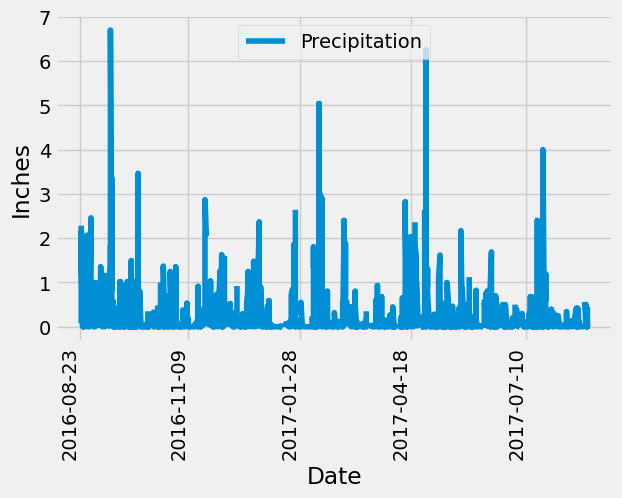

In [92]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date_dt = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")  # Converting to datetime

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= (most_recent_date_dt - dt.timedelta(days=365))).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_dataframe = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Converting the date column to datetime format
precipitation_dataframe['date'] = pd.to_datetime(precipitation_dataframe['date'])

# Sort the dataframe by date
precipitation_dataframe.sort_values('date', inplace=True)

#Indexing the date for easier plotting
precipitation_dataframe.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))

# Creating the plot
ax = precipitation_dataframe.plot(y='precipitation', legend=True)

# Setting the labels
ax.set_xlabel('Date')
ax.set_ylabel('Inches')

# Customizing the legend
ax.legend(['Precipitation'], loc='upper center')

# Rotate the x-axis labels to be upright
plt.xticks(rotation=90)

# Setting specific x-axis ticks and labels
specific_dates = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
ax.set_xticks(pd.to_datetime(specific_dates))  # Setting ticks to specific dates
ax.set_xticklabels(specific_dates)  # Setting labels to those specific dates

plt.grid(True)

# Displaying the plot
plt.show()

In [93]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_dataframe['precipitation'].describe()

# Displaying as a dataframe
summary_statistics_dataframe = summary_statistics.to_frame().rename(columns={0: 'precipitation'})

# Display the DataFrame normally
summary_statistics_dataframe

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [94]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
# Displaying
print(total_stations)

[(9,)]


In [135]:
# Design a query to find the most active stations (i.e. which stations have the most rows)
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station).label('station_count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the results in the desired format
print('[')
for index, (station, count) in enumerate(active_stations):
    if index == len(active_stations) - 1:
        print(f" ('{station}', {count})")  # No comma for the last element
    else:
        print(f" ('{station}', {count}),")  # Comma for other elements
print(']')


[
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)
]


In [138]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = 'USC00519281' # Station ID for the most active station

# Quering to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('lowest_temp'),
    func.max(Measurement.tobs).label('highest_temp'),
    func.avg(Measurement.tobs).label('average_temp')
).filter(Measurement.station == most_active_station_id).all()

# Extracting the results and formatting as a tuple
result = [(temperature_stats[0].lowest_temp, temperature_stats[0].highest_temp, temperature_stats[0].average_temp)]

# Print the results
print(result)


[(54.0, 85.0, 71.66378066378067)]


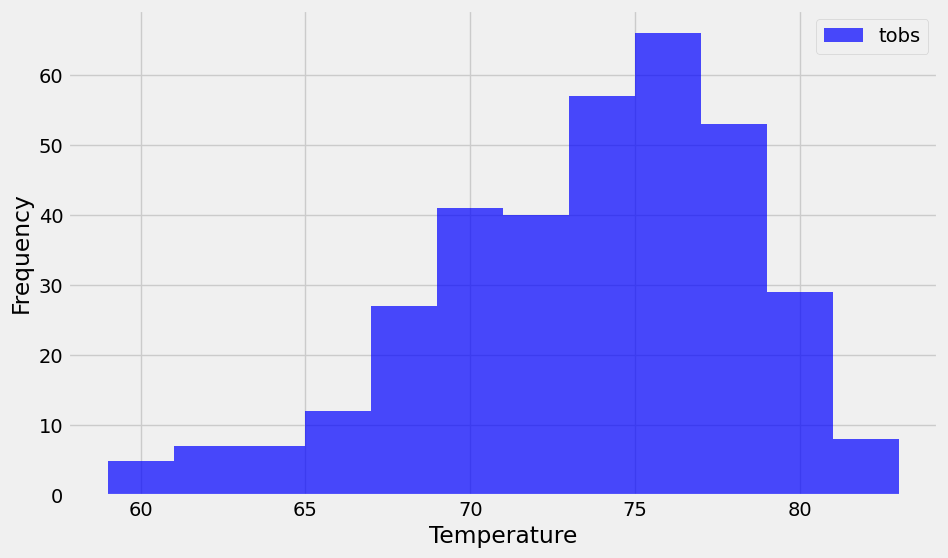

In [148]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Calculate the date one year ago from the most recent date in the database
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = datetime.strptime(last_date, '%Y-%m-%d')
year_ago = last_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
most_active_station_id = 'USC00519281'
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= year_ago.strftime('%Y-%m-%d')
).all()

# Extract temperature values into a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='blue', alpha=0.7, label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Close Session

In [149]:
# Close Session
session.close()